In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade jax
!pip install contractions
!pip install gensim


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
tsfres

In [2]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Book_review.csv to Book_review.csv


In [5]:
# Load the dataset
df = pd.read_csv('Book_review.csv')

In [6]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12000 non-null  int64 
 1   rating      12000 non-null  int64 
 2   reviewText  12000 non-null  object
 3   summary     11998 non-null  object
dtypes: int64(2), object(2)
memory usage: 375.1+ KB
None

Missing Values:
Unnamed: 0    0
rating        0
reviewText    0
summary       2
dtype: int64

First 5 rows:
   Unnamed: 0  rating                                         reviewText  \
0           0       5  This book was the very first bookmobile book I...   
1           1       1  When I read the description for this book, I c...   
2           2       5  I just had to edit this review. This book is a...   
3           3       5  I don't normally buy 'mystery' novels because ...   
4           4       5  This isn't the kind of book I normally read, a...   

        

In [7]:
# Data preprocessing
# Fill missing summaries and combine with review text
df['summary'] = df['summary'].fillna('')
df['text'] = df['summary'] + ' ' + df['reviewText']

In [8]:
df.head()

,Unnamed: 0,rating,reviewText,summary,text
0,0,5,This book was the very first bookmobile book I...,50 + years ago...,50 + years ago... This book was the very first...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!,Boring! Boring! Boring! When I read the descri...
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!,Wiggleliscious/new toy ready/!! I just had to ...
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.,Very good read. I don't normally buy 'mystery'...
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!,Great Story! This isn't the kind of book I nor...


In [9]:
df['rating'].unique()

array([5, 1, 4, 3, 2])

In [10]:
df['rating'].value_counts(normalize=True)

,proportion
rating,
5,0.250000
4,0.250000
1,0.166667
3,0.166667
2,0.166667


In [11]:
# Text cleaning functions
def remove_urls(text):
    """Remove URLs from text"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [12]:
def remove_emoji(text):
    """Remove emojis from text"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

In [13]:
def stemming(token_text):
    """Stem tokens"""
    porter = PorterStemmer()
    return [porter.stem(token) for token in token_text]

In [14]:
def lemmatization(token_text):
    """Lemmatize tokens"""
    wordnet = WordNetLemmatizer()
    return [wordnet.lemmatize(token, pos='v') for token in token_text]

In [15]:

stop_words = set(stopwords.words('english'))
def remove_stopwords(text_tokens):
    """Remove stopwords from tokenized text"""
    return [token for token in text_tokens if token not in stop_words]

In [16]:
def remove_unwanted_characters(text):
    """Remove unwanted characters from text"""
    # remove user mentions
    text = re.sub("@[A-Za-z0-9_]+", " ", text)
    # remove hashtags
    text = re.sub("#[A-Za-z0-9_]+", "", text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s.!?]', '', text)
    # remove double spaces
    text = ' '.join(text.split())
    return text.strip()

In [17]:
def remove_punctuation(text):
    """Remove punctuation from text"""
    return re.sub(r'[^\w\s]', '', text)

In [18]:
def remove_duplicate_words(text):
    """Remove consecutive duplicate words"""
    words = text.split()
    unique_words = []
    prev_word = None
    for word in words:
        if word != prev_word:
            unique_words.append(word)
        prev_word = word
    return ' '.join(unique_words)

In [19]:
def text_cleaning_pipeline(text, rule="lemmatize"):
    """Complete text cleaning pipeline"""
    # Fix contractions
    text = contractions.fix(text)
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = remove_urls(text)
    # Remove emojis
    text = remove_emoji(text)
    # Remove puncutation
    text = remove_punctuation(text)
    # Remove unwanted characters
    text = remove_unwanted_characters(text)
    # Remove Duplicate words
    text = remove_duplicate_words(text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = remove_stopwords(tokens)
    # Apply lemmatization or stemming
    if rule == "lemmatize":
        tokens = lemmatization(tokens)
    elif rule == "stem":
        tokens = stemming(tokens)
    return ' '.join(tokens)


In [20]:
# Apply text cleaning to the dataset
df['cleaned_text'] = df['text'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

In [21]:
# Show some examples of cleaned text
print("\nCleaned Text Examples:")
for i in range(3):
    print(f"Original: {df['text'][i][:100]}...")
    print(f"Cleaned: {df['cleaned_text'][i][:100]}...")
    print()


Cleaned Text Examples:
Original: 50 + years ago... This book was the very first bookmobile book I bought when I was in the school boo...
Cleaned: years ago book first bookmobile book buy school book club love story bet dollar donut love memory se...

Original: Boring! Boring! Boring! When I read the description for this book, I couldn't wait to read it. Once ...
Cleaned: bore read description book could wait read download kindle find extremely hard keep read honest stop...

Original: Wiggleliscious/new toy ready/!! I just had to edit this review. This book is an (I believe I got thi...
Cleaned: wigglelisciousnew toy ready edit review book believe get right update rewrite thank god get first ve...



Generating word cloud...


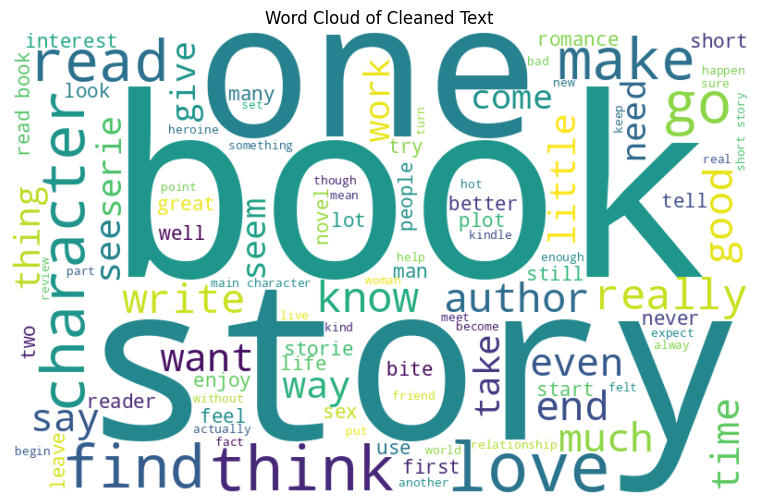

In [22]:
# Visualizing the cleaned data
print("Generating word cloud...")
# Word Cloud
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, background_color='white',
                     max_words=100, contour_width=3, contour_color='steelblue').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()

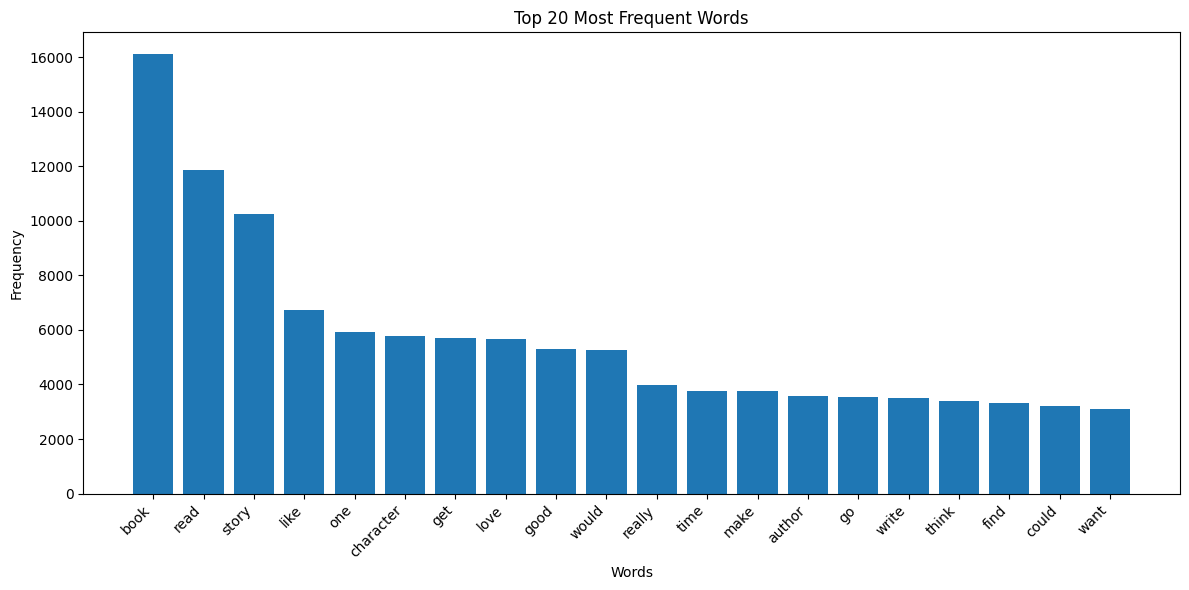

In [23]:
# Most frequent words visualization
from collections import Counter
import re
words = ' '.join(df['cleaned_text']).split()
word_counts = Counter(words)
top_20_words = dict(word_counts.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<ipython-input-24-757ea0d3f105>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


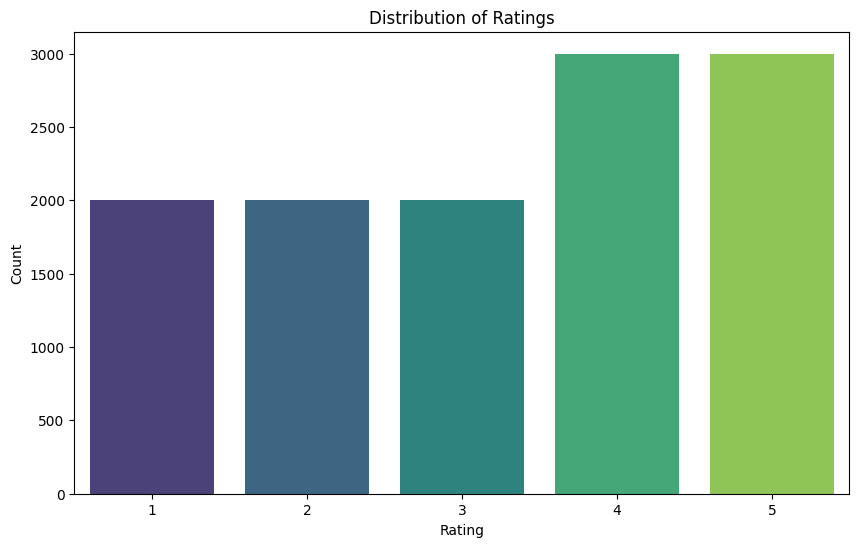

In [24]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [25]:
# Prepare data for modeling
# Target variable
print("\nUnique ratings:", sorted(df['rating'].unique()))


Unique ratings: [1, 2, 3, 4, 5]


In [26]:

from tensorflow.keras.utils import to_categorical
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }
labels = ['1', '2', '3', '4', '5']

y = df['rating'].copy()
y.replace(encoding, inplace=True)
X = df['cleaned_text']
num_classes = 5
y = to_categorical(y, num_classes)

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


In [27]:
print(y.shape)

(12000, 5)


In [28]:
# Split data into train, validation, and test sets
# Step 1: Split into 90% train+val and 10% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42)

# Step 2: Split train_val into 70% train and 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=2/9, stratify=y_train_val, random_state=42)

# Confirm shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (8400,) (8400, 5)
Validation set: (2400,) (2400, 5)
Test set: (1200,) (1200, 5)


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on training data only

# Create sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Get vocabulary info
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Add 1 for padding token
print("Vocabulary size:", vocab_size)

Vocabulary size: 31750



Sequence length statistics:
95th percentile: 180
Max length: 1083
Mean length: 55.0


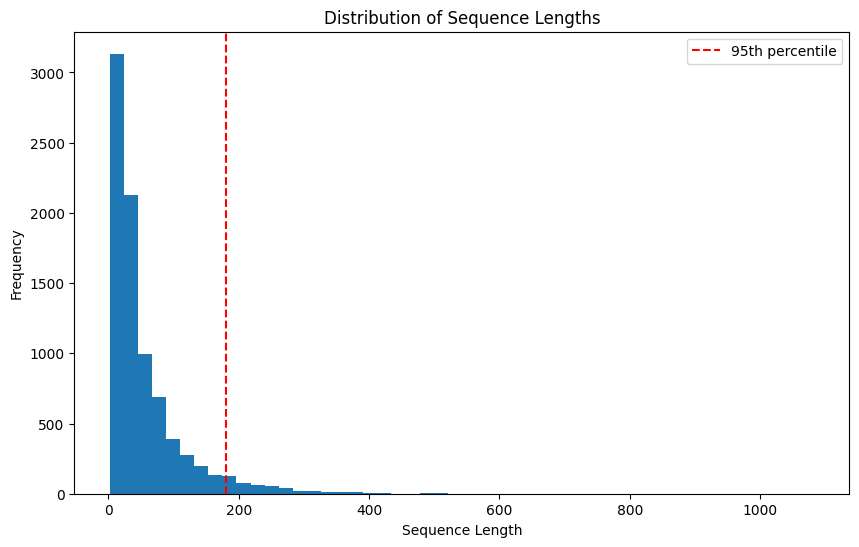

Padded sequences shapes:
X_train_pad: (8400, 180)
X_val_pad: (2400, 180)
X_test_pad: (1200, 180)


In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences
def calculate_padding_length(sequences, percentile=95):
    """Calculate padding length based on percentile of sequence lengths"""
    seq_lengths = [len(seq) for seq in sequences]
    padding_len = int(np.percentile(seq_lengths, percentile))

    print(f"\nSequence length statistics:")
    print(f"{percentile}th percentile: {padding_len}")
    print(f"Max length: {max(seq_lengths)}")
    print(f"Mean length: {np.mean(seq_lengths):.1f}")

    # Plot sequence length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=50)
    plt.axvline(padding_len, color='r', linestyle='--', label=f'{percentile}th percentile')
    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return padding_len

# Calculate padding length based on training data
padding_len = calculate_padding_length(X_train_seq)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=padding_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=padding_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=padding_len, padding='post', truncating='post')

# Check final shapes
print("Padded sequences shapes:")
print(f"X_train_pad: {X_train_pad.shape}")
print(f"X_val_pad: {X_val_pad.shape}")
print(f"X_test_pad: {X_test_pad.shape}")

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, LSTM, Bidirectional, Flatten
print(vocab_size)
print(padding_len)
print("\nBuilding Simple RNN model...")
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_shape=(padding_len,)),
    SimpleRNN(units=128, activation='tanh'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model1.summary()

31750
180

Building Simple RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 180, 128)       │     4,064,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,105,477 (15.66 MB)

 Trainable params: 4,105,477 (15.66 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print("\nBuilding LSTM model...")
model2 = Sequential()
model2.add(Embedding(vocab_size, 128,input_shape=(padding_len,)))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()


Building LSTM model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 180, 128)       │     4,064,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,119,813 (15.72 MB)

 Trainable params: 4,119,813 (15.72 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# 3. Word2Vec Embeddings

import gensim.downloader as api

# Load Word2Vec pre-trained embeddings, with robust download handling
print("Loading Word2Vec pre-trained embeddings...")
while True:  # Keep trying until successful download
    try:
        word2vec_model = api.load("word2vec-google-news-300")
        break  # Exit loop if download successful
    except Exception as e:
        print(f"Download error: {e}. Retrying...")

embedding_dim = 300

# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with vectors from Word2Vec
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in word2vec_model:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector

# Build the LSTM model with pre-trained embeddings
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_shape=(padding_len,),
                  trainable=False))
model3.add(Bidirectional(LSTM(250, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Loading Word2Vec pre-trained embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 180, 300)       │     9,525,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 180, 500)       │     1,102,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 180, 500)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    11,520,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,158,077 (84.53 MB)

 Trainable params: 12,633,077 (48.19 MB)

 Non-trainable params: 9,525,000 (36.33 MB)

In [36]:
# Import EarlyStopping from tensorflow.keras.callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [37]:
# Train Simple RNN model
print("\nTraining Simple RNN model...")
history1 = model1.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)



Training Simple RNN model...
Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.2296 - loss: 1.6255 - val_accuracy: 0.2500 - val_loss: 1.6015
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.2551 - loss: 1.5996 - val_accuracy: 0.2475 - val_loss: 1.5902
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.2450 - loss: 1.5957 - val_accuracy: 0.2454 - val_loss: 1.5930
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.2554 - loss: 1.5927 - val_accuracy: 0.2500 - val_loss: 1.5924
Epoch 5/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.2509 - loss: 1.5925 - val_accuracy: 0.2500 - val_loss: 1.5906
Epoch 6/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.2534 - loss: 1.5897 - val_accuracy: 0.2500 - val_loss: 1.5899
Epoch 7/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.2556 - loss: 1.5891 - val_accuracy: 0.2525 - val_loss: 1.5896
Epoch 8/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/ste

In [38]:
# Train LSTM model
print("\nTraining LSTM model...")
history2 = model2.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Training LSTM model...
Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 48s 170ms/step - accuracy: 0.2492 - loss: 1.5967 - val_accuracy: 0.2500 - val_loss: 1.5914
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - accuracy: 0.2488 - loss: 1.5924 - val_accuracy: 0.2587 - val_loss: 1.5888
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.2453 - loss: 1.5858 - val_accuracy: 0.2587 - val_loss: 1.5865
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.2755 - loss: 1.5599 - val_accuracy: 0.2483 - val_loss: 1.5985
Epoch 5/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 83s 173ms/step - accuracy: 0.2828 - loss: 1.5316 - val_accuracy: 0.2571 - val_loss: 1.6205
Epoch 6/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.2825 - loss: 1.5233 - val_accuracy: 0.2579 - val_loss: 1.6721
Epoch 7/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 80s 168ms/step - accuracy: 0.2938 - loss: 1.5167 - val_accuracy: 0.2500 - val_loss: 1.6413
Epoch 8/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - ac

In [39]:
# Train LSTM model with word2vec
print("\nTraining LSTM model with word2vec")
history3 = model3.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Training LSTM model with word2vec
Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.3327 - loss: 1.4457 - val_accuracy: 0.4767 - val_loss: 1.2039
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.4756 - loss: 1.1854 - val_accuracy: 0.4800 - val_loss: 1.1750
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.5425 - loss: 1.0505 - val_accuracy: 0.4829 - val_loss: 1.1783
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.6176 - loss: 0.8726 - val_accuracy: 0.4808 - val_loss: 1.2368
Epoch 5/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7166 - loss: 0.7081 - val_accuracy: 0.4854 - val_loss: 1.4231
Epoch 6/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.8044 - loss: 0.5253 - val_accuracy: 0.4575 - val_loss: 1.5837
Epoch 7/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.8547 - loss: 0.3939 - val_accuracy: 0.4471 - val_loss: 1.8832


In [40]:
# Plot training history for all models
def plot_history(histories, names):
    """Plot training & validation accuracy and loss values for multiple models"""
    plt.figure(figsize=(15, 10))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], linestyle='-', marker='o', linewidth=2, label=f'Train ({name})')
        plt.plot(history.history['val_accuracy'], linestyle='--', marker='s', linewidth=2, label=f'Val ({name})')

    plt.title('Model Accuracy', fontsize=15)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], linestyle='-', marker='o', linewidth=2, label=f'Train ({name})')
        plt.plot(history.history['val_loss'], linestyle='--', marker='s', linewidth=2, label=f'Val ({name})')

    plt.title('Model Loss', fontsize=15)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

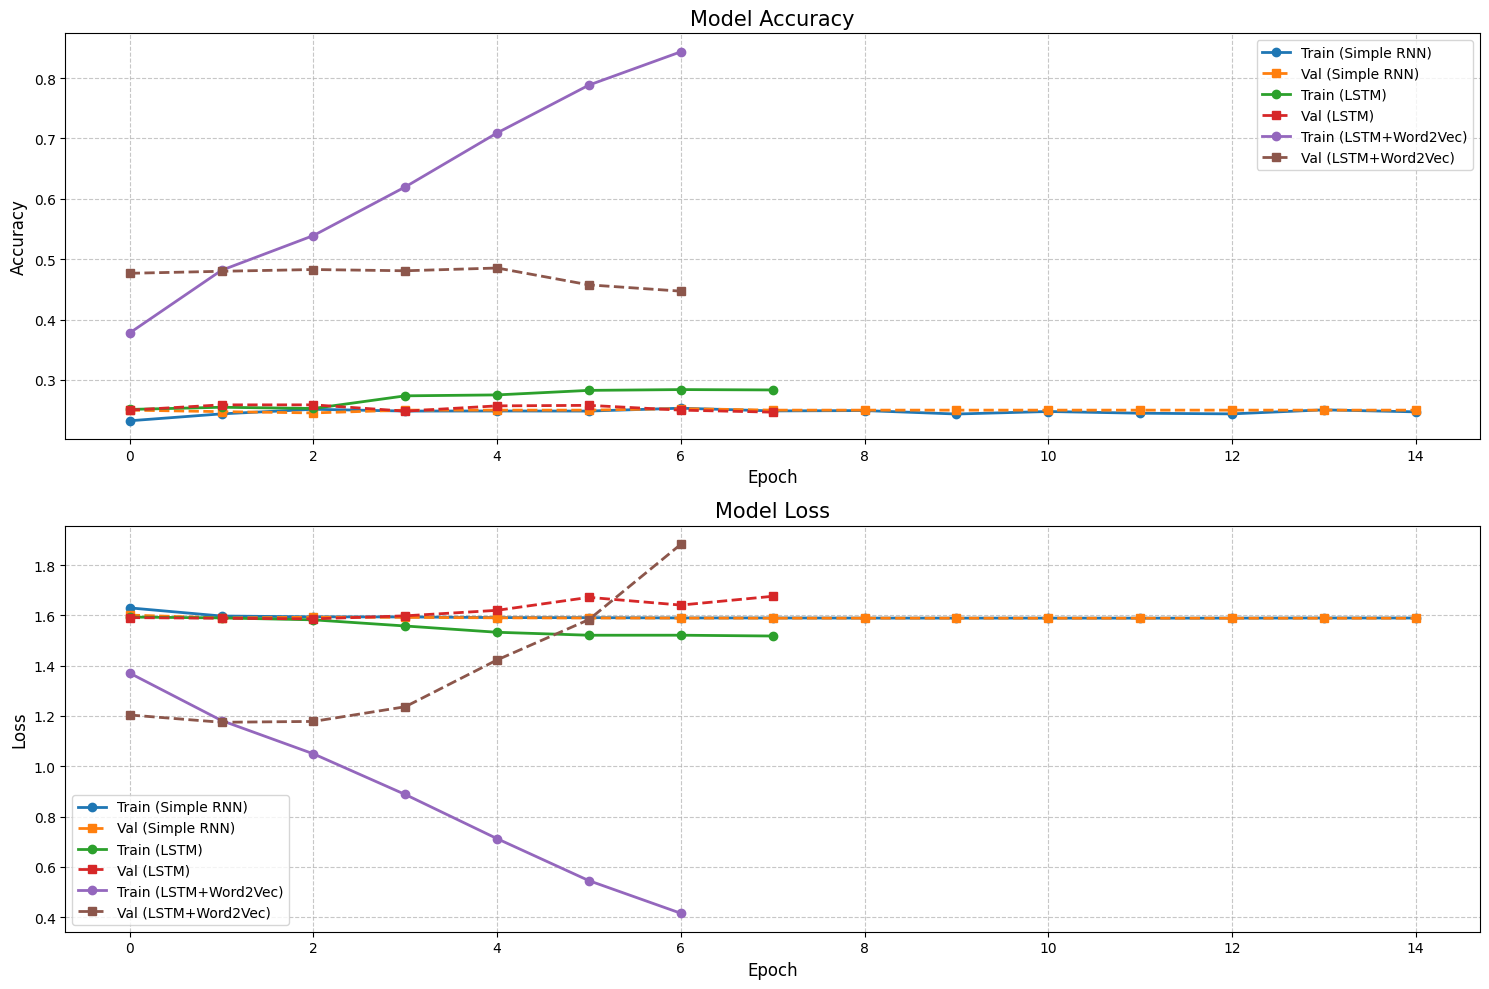

In [41]:
# Plot the training histories
plot_history(
    [history1, history2, history3],
    ['Simple RNN', 'LSTM', 'LSTM+Word2Vec']
)

In [42]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate the model and print metrics"""
    y_pred_prob = model.predict(X_test)

    # Detect if it's binary classification
    if y_pred_prob.shape[1] == 1:
        # Binary classification
        y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
        if len(y_test.shape) > 1 and y_test.shape[1] == 1:
            y_test_classes = y_test.flatten()
        else:
            y_test_classes = y_test
        num_classes = 2
    else:
        # Multi-class classification
        y_pred_classes = np.argmax(y_pred_prob, axis=1)
        y_test_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
        num_classes = y_pred_prob.shape[1]

    # Calculate accuracy
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f'\n{model_name} Test Accuracy: {accuracy:.4f}')

    # Print classification report
    print(f'\n{model_name} Classification Report:')
    print(classification_report(y_test_classes, y_pred_classes))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[f'Class {i}' for i in range(num_classes)],
                yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.title(f'{model_name} Confusion Matrix (Normalized)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy


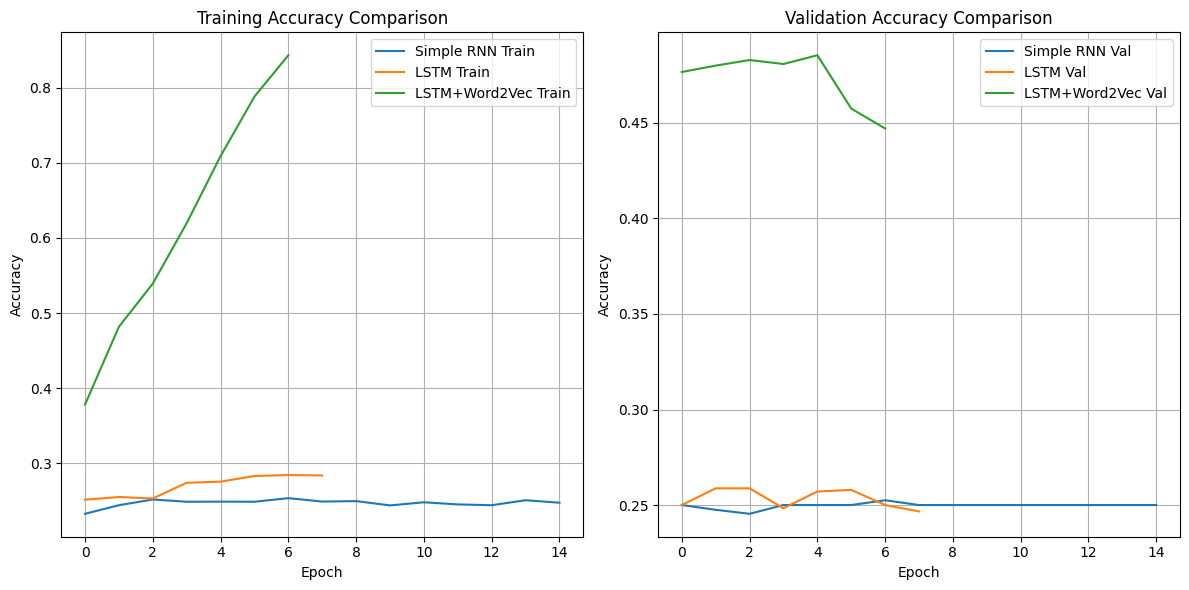

In [43]:
def plot_accuracy_comparison(histories, model_names):
    plt.figure(figsize=(12, 6))

    # Plot training accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.title('Training Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Validation Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_accuracy_comparison([history1, history2, history3],
                         ['Simple RNN', 'LSTM', 'LSTM+Word2Vec'])

In [44]:
import pandas as pd

def create_comparison_table(histories, model_names):
    comparison_data = []

    for history, name in zip(histories, model_names):
        # Get final epoch metrics
        final_epoch = len(history.history['accuracy']) - 1
        train_acc = history.history['accuracy'][final_epoch]
        val_acc = history.history['val_accuracy'][final_epoch]
        train_loss = history.history['loss'][final_epoch]
        val_loss = history.history['val_loss'][final_epoch]

        comparison_data.append({
            'Model': name,
            'Train Accuracy': f"{train_acc:.4f}",
            'Val Accuracy': f"{val_acc:.4f}",
            'Train Loss': f"{train_loss:.4f}",
            'Val Loss': f"{val_loss:.4f}",
            'Epochs': final_epoch + 1
        })

    return pd.DataFrame(comparison_data)


comparison_df = create_comparison_table([history1, history2, history3],
                                      ['Simple RNN', 'LSTM', 'LSTM+Word2Vec'])
print(comparison_df)

           Model Train Accuracy Val Accuracy Train Loss Val Loss  Epochs
0     Simple RNN         0.2471       0.2500     1.5898   1.5891      15
1           LSTM         0.2835       0.2467     1.5182   1.6763       8
2  LSTM+Word2Vec         0.8436       0.4471     0.4149   1.8832       7


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Simple RNN Test Accuracy: 0.2500

Simple RNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.25      1.00      0.40       300
           4       0.00      0.00      0.00       300

    accuracy                           0.25      1200
   macro avg       0.05      0.20      0.08      1200
weighted avg       0.06      0.25      0.10      1200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


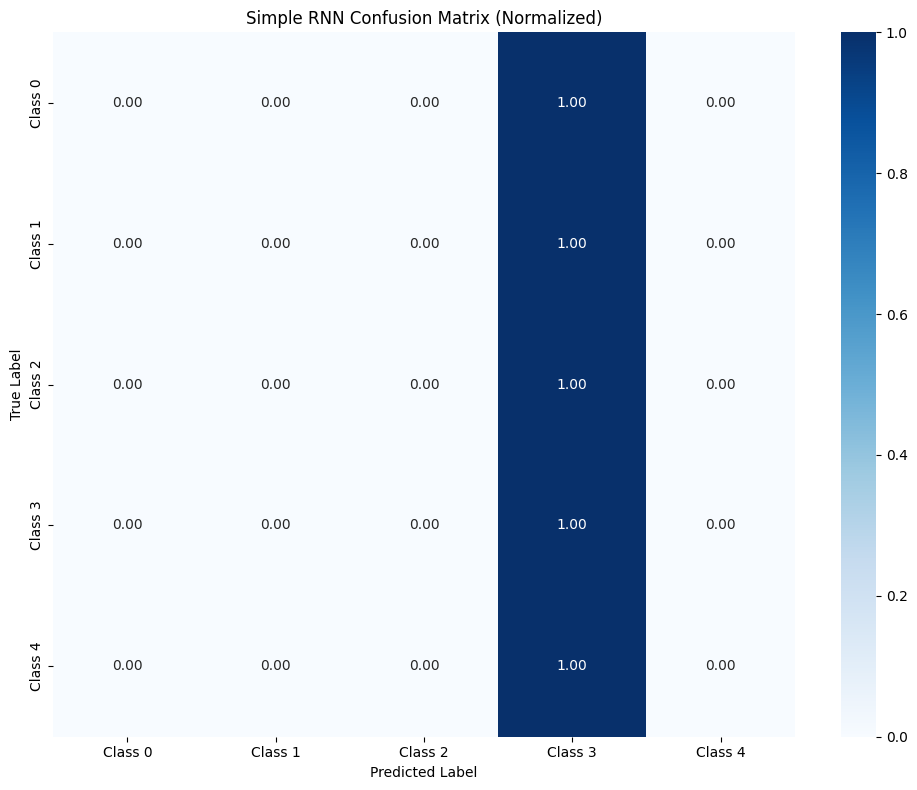

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

LSTM Test Accuracy: 0.2450

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.18      0.03      0.05       300
           4       0.25      0.95      0.39       300

    accuracy                           0.24      1200
   macro avg       0.09      0.20      0.09      1200
weighted avg       0.11      0.24      0.11      1200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


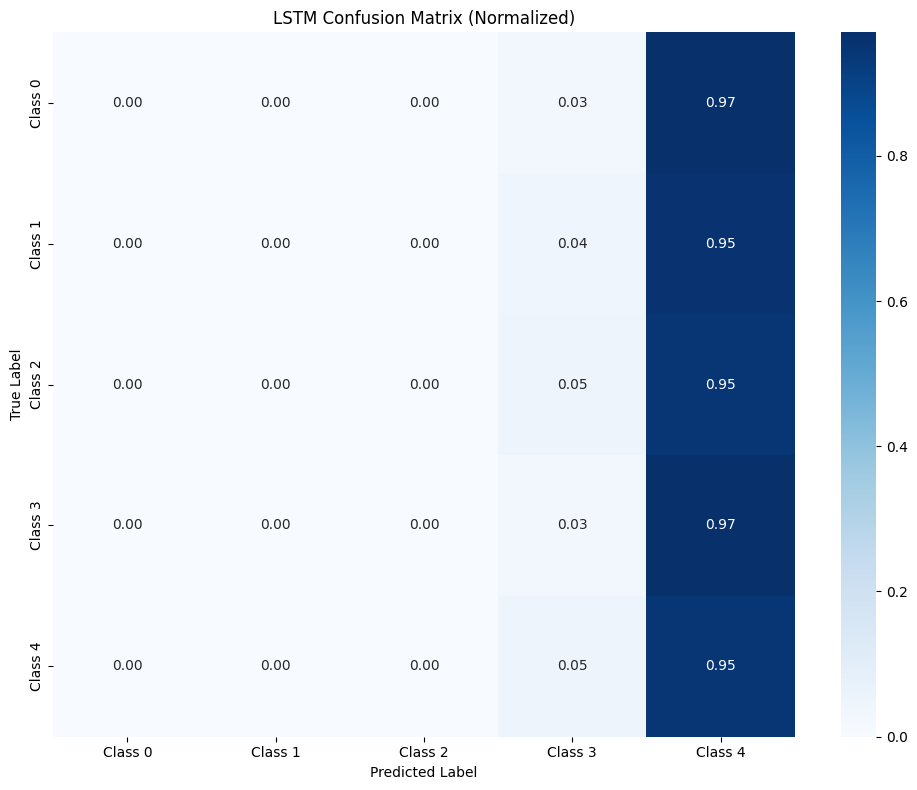

38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step

LSTM+Word2Vec Test Accuracy: 0.4842

LSTM+Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       200
           1       0.39      0.40      0.40       200
           2       0.38      0.31      0.34       200
           3       0.42      0.56      0.48       300
           4       0.63      0.58      0.61       300

    accuracy                           0.48      1200
   macro avg       0.49      0.47      0.47      1200
weighted avg       0.49      0.48      0.48      1200



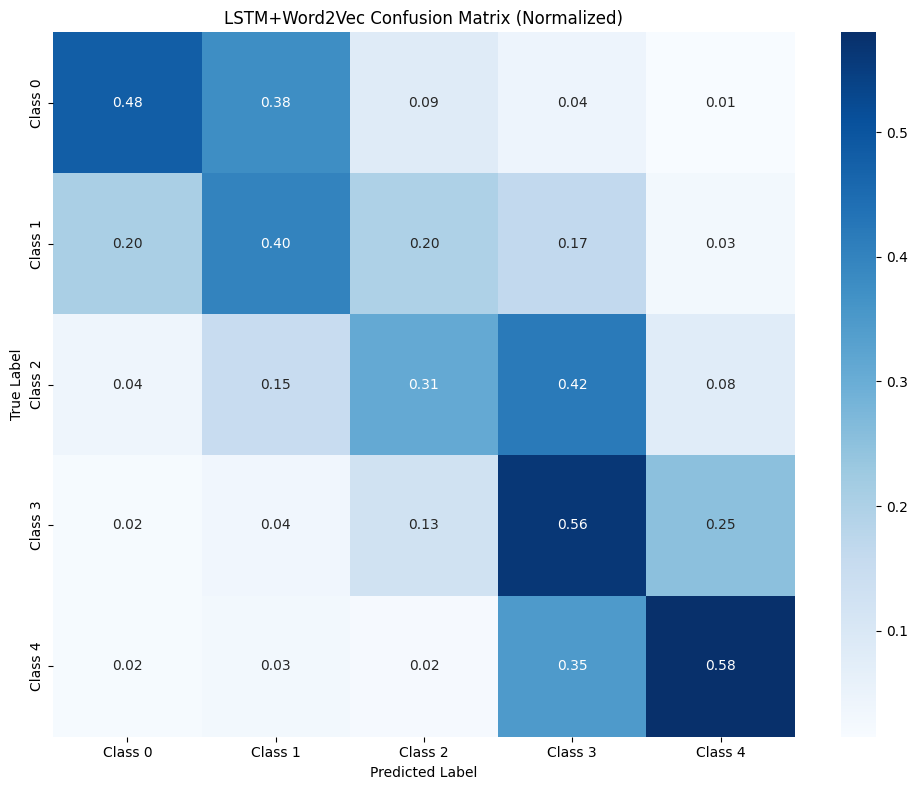

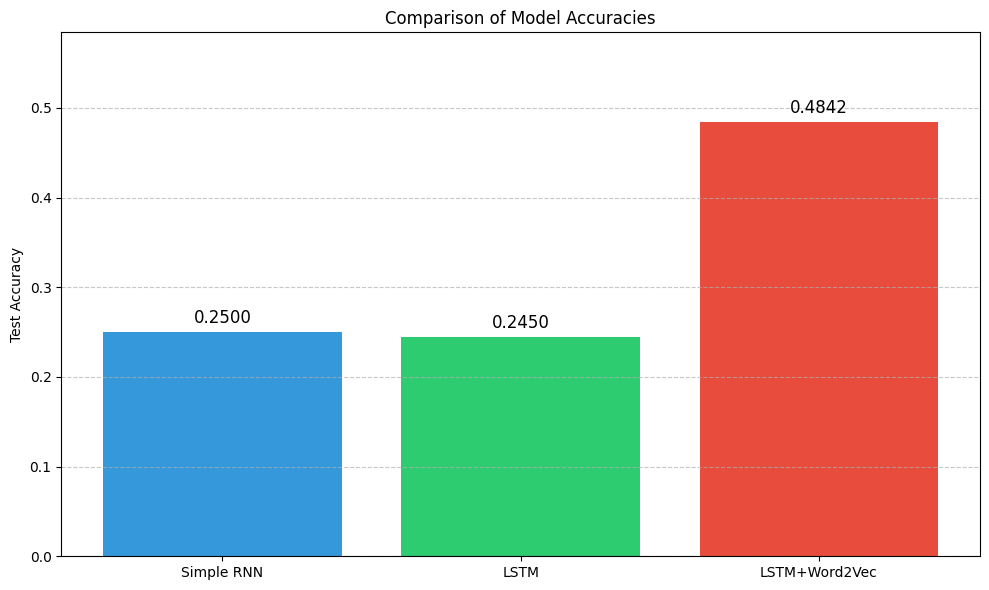

In [45]:
# Compare model performances
model_names = ['Simple RNN', 'LSTM', 'LSTM+Word2Vec']

# Evaluate each model and store accuracies
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc1 = evaluate_model(model1, X_test_pad, y_test, model_names[0])  # Simple RNN
acc2 = evaluate_model(model2, X_test_pad, y_test, model_names[1])  # LSTM
acc3 = evaluate_model(model3, X_test_pad, y_test, model_names[2])  # LSTM+Word2Vec


accuracies = [acc1, acc2, acc3]
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=12)
plt.ylim(0, max(accuracies) + 0.1)
plt.title('Comparison of Model Accuracies')
plt.ylabel('Test Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [46]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


In [47]:
import gradio as gr
# Function to preprocess text and make prediction
def predict_rating(text, model_choice):
    """Preprocess input text and predict rating"""
    # Apply the same preprocessing steps
    cleaned_text = text_cleaning_pipeline(text, rule="lemmatize")

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=padding_len, padding='post', truncating='post')

    # Select model based on choice
    if model_choice == "Simple RNN":
        model = model1
    elif model_choice == "LSTM":
        model = model2
    else:  # LSTM+Word2Vec
        model = model3

    # Make prediction
    prediction = model.predict(padded)[0]

    # Get the predicted class (add 1 to get back to the original rating scale)
    predicted_class = np.argmax(prediction) + 1

    # Calculate confidence for each class
    confidence = prediction * 100  # Convert to percentage

    # Create result dictionary
    result = {
        f"Rating {i+1} Star": f"{confidence[i]:.2f}%" for i in range(len(confidence))
    }

    # Add predicted rating
    result["Predicted Rating"] = f"{predicted_class} Star{'s' if predicted_class > 1 else ''}"

    return result

In [48]:
 #Create Gradio interface
def create_gradio_interface():
    with gr.Blocks(title="Book Review Rating Predictor") as iface:
        gr.Markdown("# Book Review Rating Predictor")
        gr.Markdown("Enter a book review to predict its rating (1-5 stars)")

        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(
                    label="Enter Book Review",
                    placeholder="Type your book review here...",
                    lines=5
                )
                model_choice = gr.Radio(
                    choices=["Simple RNN", "LSTM", "LSTM+Word2Vec"],
                    label="Select Model",
                    value="LSTM+Word2Vec"
                )
                predict_btn = gr.Button("Predict Rating")

            with gr.Column():
                output = gr.JSON(label="Prediction Results")

        predict_btn.click(
            fn=predict_rating,
            inputs=[text_input, model_choice],
            outputs=output
        )

        # Add example inputs
        gr.Examples(
            [
                ["This book was amazing! The characters were well-developed and the plot kept me engaged throughout.", "LSTM+Word2Vec"],
                ["I couldn't finish this book. The writing was terrible and the story was boring.", "LSTM+Word2Vec"],
                ["An average read. Some parts were interesting but overall it was forgettable.", "LSTM+Word2Vec"]
            ],
            inputs=[text_input, model_choice]
        )

    return iface

In [49]:
# Create and launch the interface
interface = create_gradio_interface()
# Launch the interface (for Colab, use share=True)
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4d871e8f8a96ec4964.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
